In [ ]:
import pandas as pd
from numpy import log, dot, e
import numpy as np
from numpy.random import rand, randint
import matplotlib.pyplot as plt
epsilon = 0.0000000000000000001

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## **Data Cleaning**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are some missing data of the Age feature. The number of missing data is small enough for easonable replacement with some form of imputation. For the Cabin column, it missing too many values, so I will drop it. For Embarked feature, there are only 2 values missing, just drop those 2 rows.

**Filling in missing age data**

Filling in the mean age of passengers by passenger class.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


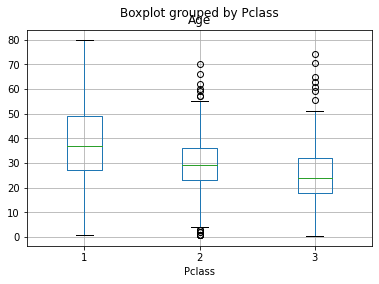

In [ ]:
df.boxplot(column='Age',by='Pclass')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age. For class 1, the average age looks like 37. For class 2, it's about 29. For class 3, it's about 24.

In [ ]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [ ]:
df['Age'] = df[['Age','Pclass']].apply(impute_age, axis=1)

**Drop Cabin cloumn and the row in Embarked that is NaN**

In [ ]:
# drop Cabin column
df.drop('Cabin', axis=1, inplace=True)
#drop rows in Embarked that is NaN
df.dropna(inplace=True)

In [ ]:
df =df.reset_index()
df

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
885,887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
886,888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,S
887,889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        889 non-null    int64  
 1   PassengerId  889 non-null    int64  
 2   Survived     889 non-null    int64  
 3   Pclass       889 non-null    int64  
 4   Name         889 non-null    object 
 5   Sex          889 non-null    object 
 6   Age          889 non-null    float64
 7   SibSp        889 non-null    int64  
 8   Parch        889 non-null    int64  
 9   Ticket       889 non-null    object 
 10  Fare         889 non-null    float64
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.5+ KB


## **Converting Categorical Features**

In [ ]:
df = pd.get_dummies(df, columns=['Sex','Embarked'], drop_first=True)
#drop PassengerID, Name and Ticket, they are not neccessary for model.
df.drop(['PassengerId','Name','Ticket', 'index'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [ ]:
X = df.drop('Survived',axis=1)
y = df['Survived']

In [ ]:
X.shape, y.shape

((889, 8), (889,))

## **1.Try our quick algorigthm and see if it's any good**

In [ ]:
# Define Logistic model
def sigmoid(z):
    return(1/(1+e**(-z)))


# Define loss
def cost_function(X,y,weights):
    y_hat = sigmoid(dot(X, weights))
    pred_1 = y*log(y_hat+epsilon)
    pred_0 = (1-y)*log(1-y_hat+epsilon)
    mean = -sum(pred_1 + pred_0)/len(X)
    return(mean)

# Fit model
def fit(X,y,epochs=25,lr=0.01):
    loss = []
    weights = rand(X.shape[1])
    n = len(X)
    best_weights = []
    best_cost = 10000000
    cost = []

    for _ in range(epochs):
        y_hat = sigmoid(dot(X, weights))
        delta = lr * dot(X.T, y_hat-y)/n
        weights -= delta 
        c = cost_function(X,y,weights)
        loss.append(c)

        if c < best_cost:
            best_cost = c
            best_weights = weights
            cost.append(c)

    return(loss, best_cost,best_weights)


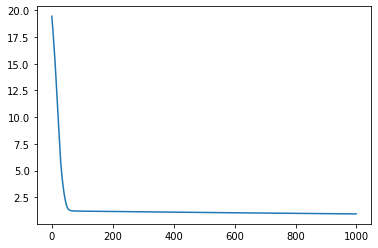

In [ ]:
loss, cost, weights = fit(X,y,epochs=1000, lr=0.001)
plt.plot(loss)

In [ ]:
#Black box
def predict(X, weights):
    z = sigmoid(dot(X,weights))
    return([1 if i>0.5 else 0 for i in z])

#F_Score
def confusion(X,y,weights):
  y_hat = predict(X, weights)
  errors = y_hat-y
  fp = len([e for e in errors if e==1])
  fn = len([e for e in errors if e==-1])
  tp = len([errors[i] for i in range(len(y)) if errors[i]==0 and y[i]==1])
  tn = len([errors[i] for i in range(len(y)) if errors[i]==0 and y[i]==0])
  return(fp,fn,tp,tn)

def f_score(X,y, weights):
  fp,fn,tp,tn = confusion(X,y,weights)
  f = tp / (tp + 0.5*(fp+fn))
  return(f)

In [ ]:
# y_hat = predict(X, weights)
print('F_score is: ', f_score(X,y,weights))

F_score is:  0.45594405594405596


## **2.Try SKLearn on the same data, see if you do any better**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_hat_LR = logmodel.predict(X)

In [ ]:
logmodel.n_iter_

array([161], dtype=int32)

In [ ]:
logmodel.score(X,y)

0.8065241844769404

The f score is about 0.81, higher than the quick algorigthm.

## **3.Combine random walk with Logistic regression -- does it improve results? If you add randomness ("occasional kick in the butt") to a gradient descent, does it improve?**

In [ ]:
def fit_random_gradient_descent(X,y,epochs=25,lr=0.01):
  loss = []
  weights = rand(X.shape[1])
  n = len(X)
  best_weights = []
  best_cost = 1000000000
  cost = []

  for i in range(epochs):
    if i%100==0:    #add randomness
        weights = rand(X.shape[1])
    else:
        y_hat = sigmoid(dot(X,weights))
        delta = lr* dot(X.T, y_hat-y)/n
        weights -= delta
    c=cost_function(X,y,weights)
    loss.append(c)

    if c < best_cost:
      best_cost=c
      best_weights=weights
      cost.append(c)


  return(loss,best_cost,best_weights)

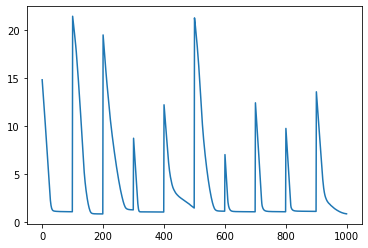

In [ ]:
loss, cost, weights = fit_random_gradient_descent(X,y,epochs=1000, lr=0.001)
plt.plot(loss)

It seems it didn't improve.

## **4.How do we optimize the learning rate? -- you can use gradient descent; balance oscillations with speed of convergeance**

To make the learning rate more and more small to avoid missing the minimum point.

In [ ]:
def fit_decreasing_learning_rate(X,y,epochs=25,lr=0.01):
  loss = []
  weights = rand(X.shape[1])
  n = len(X)
  best_weights = []
  best_cost = 1000000000
  cost = []

  for i in range(epochs):
    y_hat = sigmoid(dot(X,weights))
    lr = lr * 0.8    # decreasing learning rate
    delta = lr* dot(X.T, y_hat-y)/n
    weights -= delta
    c=cost_function(X,y,weights)
    loss.append(c)

    if c < best_cost:
      best_cost=c
      best_weights=weights
      cost.append(c)

  return(loss,best_cost,best_weights)

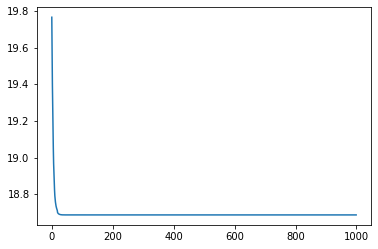

In [ ]:
loss, cost, weights = fit_decreasing_learning_rate(X,y,epochs=1000, lr=0.001)
plt.plot(loss)

In [ ]:
print('F_score is: ', f_score(X,y,weights))

F_score is:  0.5532953620829943


The f score is better than the origional one.
